In [18]:
# -------------------------------------------------------------------------
# CELDA 1: Configuración, Proyección de Población y Consolidación de Datos
# -------------------------------------------------------------------------

import pandas as pd
import numpy as np
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report


# A. PROYECCIÓN DE POBLACIÓN (CONAPO 2025)
# Usaremos esto como el denominador de la Tasa de Incidencia (TI)
POBLACION_2025_PROYECCION = {
    # CÓDIGO_INEGI: (NOMBRE_ESTADO, POBLACIÓN_TOTAL_2025)
    1: ('Aguascalientes', 1512400), 2: ('Baja California', 3968300), 3: ('Baja California Sur', 850700),
    4: ('Campeche', 1011800), 5: ('Coahuila de Zaragoza', 3328500), 6: ('Colima', 775100),
    7: ('Chiapas', 6000100), 8: ('Chihuahua', 3998500), 9: ('Ciudad de México', 9386700),
    10: ('Durango', 1913400), 11: ('Guanajuato', 6555200), 12: ('Guerrero', 3724300),
    13: ('Hidalgo', 3327600), 14: ('Jalisco', 8847600), 15: ('México', 18016500),
    16: ('Michoacán de Ocampo', 4975800), 17: ('Morelos', 2056000), 18: ('Nayarit', 1294800),
    19: ('Nuevo León', 6231200), 20: ('Oaxaca', 4432900), 21: ('Puebla', 6886400),
    22: ('Querétaro', 2603300), 23: ('Quintana Roo', 1989500), 24: ('San Luis Potosí', 2931400),
    25: ('Sinaloa', 3274600), 26: ('Sonora', 3154100), 27: ('Tabasco', 2601900),
    28: ('Tamaulipas', 3682900), 29: ('Tlaxcala', 1421000), 30: ('Veracruz de Ignacio de la Llave', 8871300),
    31: ('Yucatán', 2561900), 32: ('Zacatecas', 1698200)
}


# B. CONSOLIDACIÓN DE CSVs
# ⚠️ ADAPTAR ESTA LISTA DE ARCHIVOS A TUS 5 RUTAS REALES
archivo_nombres = [
    '../data/dengue_2020.csv',
    '../data/dengue_2021.csv',
    '../data/dengue_2022.csv',
    '../data/dengue_2023.csv',
    '../data/dengue_2024.csv',
    '../data/dengue_2025.csv' 
]

df_list = []
for file_name in archivo_nombres:
    try:
        # Nota: Asegúrate de que las rutas relativas sean correctas (ej. '../data/' o '../')
        df_anual = pd.read_csv(file_name) 
        df_list.append(df_anual)
    except FileNotFoundError:
        print(f"ADVERTENCIA: Archivo {file_name} no encontrado. Revisa la ruta.")

if not df_list:
    raise FileNotFoundError("ERROR CRÍTICO: No se pudo cargar ningún archivo CSV para entrenamiento.")

df_consolidado = pd.concat(df_list, ignore_index=True)
print(f"Total de registros históricos consolidados: {len(df_consolidado)}")


# C. LIMPIEZA INICIAL
df = df_consolidado.copy()
df['FECHA_SIGN_SINTOMAS'] = pd.to_datetime(df['FECHA_SIGN_SINTOMAS'], errors='coerce')
df.dropna(subset=['FECHA_SIGN_SINTOMAS'], inplace=True)
df_confirmados = df[df['ESTATUS_CASO'] == 1].copy()


# D. MAPEO DE POBLACIÓN (USANDO 2025)
df_poblacion = pd.DataFrame(POBLACION_2025_PROYECCION).T
df_poblacion.columns = ['NOMBRE_ESTADO', 'POBLACION']
df_poblacion.index.name = 'ENTIDAD_RES'
df_confirmados = df_confirmados.merge(df_poblacion, on='ENTIDAD_RES', how='left')
df_confirmados.dropna(subset=['POBLACION'], inplace=True) # Eliminar filas con códigos inválidos

Total de registros históricos consolidados: 1171134


In [19]:
# ----------------------------------------------------
# CELDA 2: Agregación, Lag Features y Creación del Target (Y)
# ----------------------------------------------------

# 1. Agregación a Series de Tiempo (df_ts)
df_ts = (
    df_confirmados.groupby(['ENTIDAD_RES', 'NOMBRE_ESTADO', 'POBLACION'])
    .resample('W', on='FECHA_SIGN_SINTOMAS')
    .size()
    .reset_index(name='CASOS_CONFIRMADOS')
)

# 2. Calcular la Tasa de Incidencia (Métrica profesional)
df_ts['TASA_INCIDENCIA'] = (df_ts['CASOS_CONFIRMADOS'] / df_ts['POBLACION']) * 100000

# 3. Lag Features (Memoria de 1, 4 y 12 semanas)
lags = [1, 4, 12]
for lag in lags:
    # Shift aplica el rezago por grupo (estado)
    df_ts[f'TI_LAG_{lag}W'] = df_ts.groupby('NOMBRE_ESTADO')['TASA_INCIDENCIA'].shift(lag)
    df_ts[f'CASOS_LAG_{lag}W'] = df_ts.groupby('NOMBRE_ESTADO')['CASOS_CONFIRMADOS'].shift(lag)

df_ts.dropna(inplace=True) # Eliminar las primeras filas sin lag features

# 4. Features de Tiempo y Codificación Geográfica
df_ts['SEMANA_DEL_ANIO'] = df_ts['FECHA_SIGN_SINTOMAS'].dt.isocalendar().week.astype(int)
df_ts['MES'] = df_ts['FECHA_SIGN_SINTOMAS'].dt.month
le = LabelEncoder()
df_ts['ENTIDAD_CODED'] = le.fit_transform(df_ts['NOMBRE_ESTADO'])

# 5. Definir Umbral de Riesgo (Target Y)
# El umbral ahora se calcula sobre 6 años de historia (2020-2025), haciéndolo más robusto.
umbral_riesgo = df_ts['TASA_INCIDENCIA'].quantile(0.75)
df_ts['RIESGO_BROTE'] = np.where(df_ts['TASA_INCIDENCIA'] > umbral_riesgo, 1, 0)

print(f"Umbral de Riesgo (Percentil 75) calculado con 6 años de datos: {umbral_riesgo:.2f}")
print(f"Filas listas para entrenamiento (6 años - 32 estados): {len(df_ts)}")

Umbral de Riesgo (Percentil 75) calculado con 6 años de datos: 0.62
Filas listas para entrenamiento (6 años - 32 estados): 9376


C:\Users\es982\AppData\Local\Temp\ipykernel_7988\3086163519.py:9: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


In [20]:
# ----------------------------------------------------
# CELDA 3: Modelado y Entrenamiento
# ----------------------------------------------------

# Definir Features (X) y Target (Y)
features = [
    'TI_LAG_1W', 'TI_LAG_4W', 'CASOS_LAG_1W', 'CASOS_LAG_4W', 
    'SEMANA_DEL_ANIO', 'MES', 'ENTIDAD_CODED'
]
X = df_ts[features]
Y = df_ts['RIESGO_BROTE'] 

# División de Datos (Entrenamiento y Prueba)
# stratify=Y es vital para mantener la proporción de Riesgo Alto
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, # Usamos 80/20 ya que tenemos 6 años de datos
    random_state=42, 
    stratify=Y
)

# Definición y Entrenamiento del Modelo
rf_classifier = RandomForestClassifier(
    n_estimators=200, # Aumentamos los árboles para aprovechar 6 años de datos
    random_state=42, 
    class_weight='balanced', # Esencial para el desbalance
    max_depth=15, # Mayor profundidad para capturar patrones complejos
    min_samples_split=5,
    min_samples_leaf=2
)

print("\nEntrenando Random Forest Classifier con 6 años de historia (2020-2025)...")
rf_classifier.fit(X_train, Y_train)


Entrenando Random Forest Classifier con 6 años de historia (2020-2025)...


,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



✅ AUC-ROC Score FINAL (6 años de datos 2020-2025): 0.9916

--- Reporte de Clasificación Detallado ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1407
           1       0.92      0.91      0.92       469

    accuracy                           0.96      1876
   macro avg       0.95      0.94      0.95      1876
weighted avg       0.96      0.96      0.96      1876



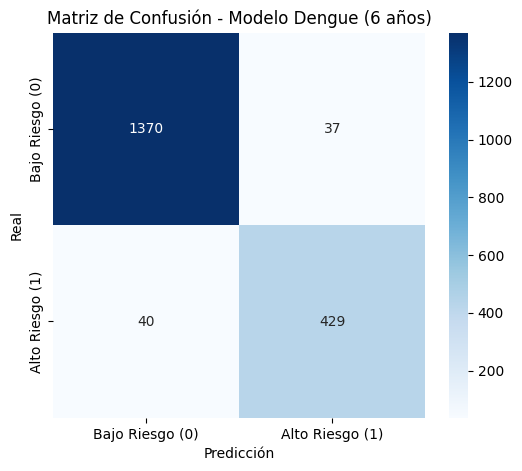

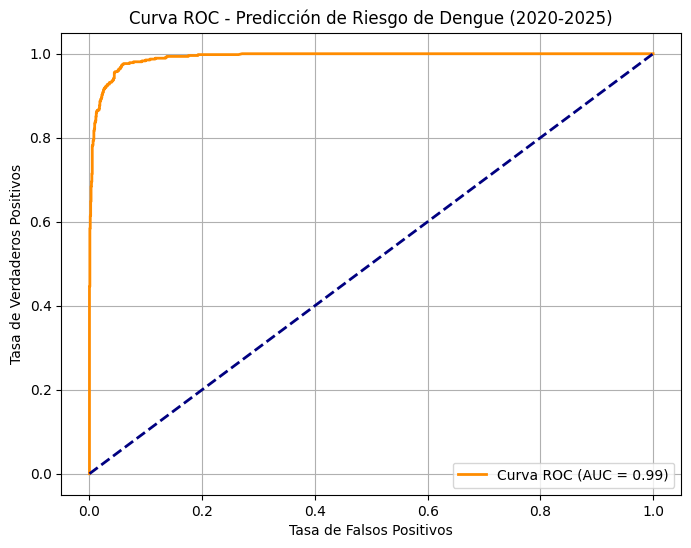

In [21]:
# ----------------------------------------------------
# CELDA 4: Evaluación y Visualización
# ----------------------------------------------------

Y_pred = rf_classifier.predict(X_test)
Y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# 1. AUC-ROC Score (Métrica principal)
auc_score = roc_auc_score(Y_test, Y_pred_proba)
print(f"\n✅ AUC-ROC Score FINAL (6 años de datos 2020-2025): {auc_score:.4f}")

# 2. Reporte de Clasificación (CRÍTICO: Ver el Recall de la clase 1)
print("\n--- Reporte de Clasificación Detallado ---")
print(classification_report(Y_test, Y_pred))

# 3. Matriz de Confusión (Visualización)
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bajo Riesgo (0)', 'Alto Riesgo (1)'], 
            yticklabels=['Bajo Riesgo (0)', 'Alto Riesgo (1)'])
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Modelo Dengue (6 años)')
plt.show()

# 4. Curva ROC (Visualización Profesional)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Predicción de Riesgo de Dengue (2020-2025)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [22]:
# ----------------------------------------------------
# CELDA 5: Guardar Artefactos (¡Conexión con Flask!)
# ----------------------------------------------------

# Asegúrate de que la carpeta 'backend/' exista en la raíz de tu proyecto.
try:
    joblib.dump(rf_classifier, '../backend/model.pkl')
    joblib.dump(le, '../backend/label_encoder.pkl') 

    print("\nModelos GUARDADOS. ¡El modelo Random Forest está listo para producción!")
    print("El backend de Flask usará estos archivos.")

except FileNotFoundError:
    print("¡ERROR! Asegúrate de que la carpeta 'backend/' exista.")


Modelos GUARDADOS. ¡El modelo Random Forest está listo para producción!
El backend de Flask usará estos archivos.
